# Reionization

## Standard model of reionization used in CMB; constraints on reionization history from CMB optical depth
### Dhiraj Kumar Hazra, IMSc, Chennai, India

Topics of discussion

* Tanh Model of Reionization
* Optical depth
* Neutral Hydrogen data
* Constraints


### References

* Any CMB survey paper on the estimation of optical depth
* Bouwens et. al. 2015, https://arxiv.org/abs/1503.08228
* Hu, Holder https://arxiv.org/abs/astro-ph/0303400
* Hazra, Smoot 2017


**This notebook assumes flat Universe. You need to change some formulae in order to use spatial curvature**


In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

#### Import necessary libraries

In [3]:
import numpy as np
from astropy.cosmology import Planck15 as cosmo
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy import integrate 
rc('text', usetex=True)

**Constants** 

We will need constants such as speed of light and unit conversion factors etc. I have stored them in constants.py file

**Planck**

While we will constrain the cosmological parameters using observations in the upcoming lectures, to calculate cosmological quantities based on a baseline cosmology and the baseline parameter values, we need the best fit/mean values of the parameters. Here in Planckbf.py I have noted down the Planck 2018 baseline bestfits. 


In [4]:
import constants as const 
import Planckbf as Pl

## Friedmann Equations

1. $$H^2=\left(\frac{\dot a}{a}\right)^2=\frac{8\pi G}{3}\rho - \frac{Kc^2}{a^2}$$

2. $$\dot{H}+H^2=\left(\frac{\ddot a}{a}\right)=-\frac{4\pi G}{3}\left(\rho+\frac{3p}{c^2}\right)$$

### Defining redshifts

In [5]:

# Concept of Redshift
def az(z):
    az=1.0/(1+z)
    return az

## Parameterizing the reionization history

### Tanh parametrization

Electron fraction ($x_e(z)$):

$$x_e(z)=\frac{1}{2}\left[1+\tanh\left(\frac{y(z_{re})-y}{\Delta_y}\right)\right]$$
$$y(z)=(1+z)^{3/2}$$

In [6]:
def xeH(a,deltaz,zre):
    z=1.0/a-1.0
    y=(1.0+z)**(3.0/2.0)
    yzre=(1.0+zre)**(3.0/2.0)
    dy=(3.0/2.0)*np.sqrt(1.0+zre)*deltaz
    xeH=(1.0/2.0)*(1.0+np.tanh((yzre-y)/dy))
    return xeH

def xeHe(a):
    deltaz=0.5
    zre=3.5
    z=1.0/a-1.0
    y=(1.0+z)
    yzre=(1.0+zre)
    dy=deltaz
    xeHe=(1.0/2.0)*(1.0+np.tanh((yzre-y)/dy))
    return xeHe

def xe(a,deltaz,zre):
    fHe=const.yHe/(const.mass_ratio_He_H*(1.0-const.yHe))
    xe=(1.0+fHe)*xeH(a,deltaz,zre)+fHe*xeHe(a)
    return xe


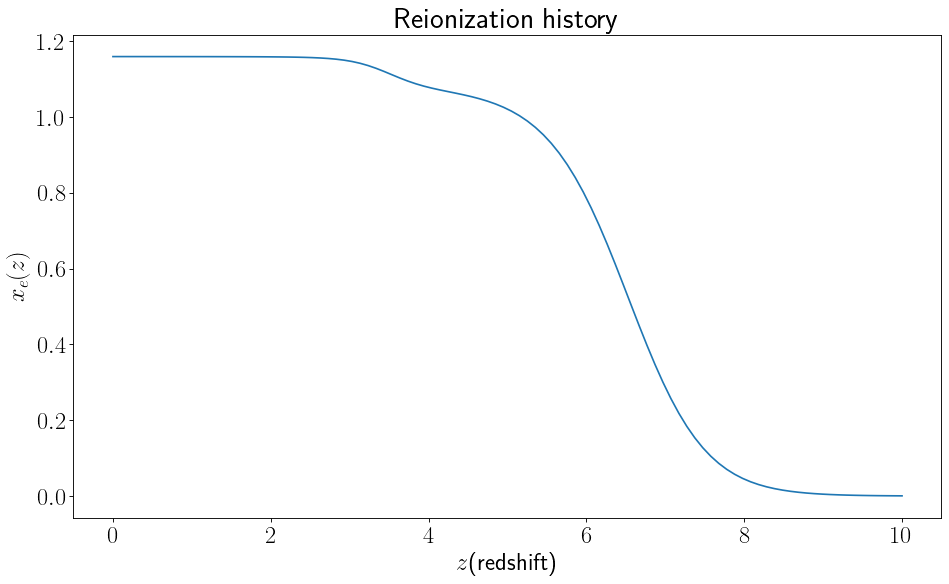

In [7]:
z=np.linspace(10,0,100)
a=np.zeros(len(z))
xez=np.zeros(len(z))
a=az(z)
zre=6.5
deltaz=1.0
xez=xe(a,deltaz,zre)

plt.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(z,xez)
plt.xlabel("$z$(redshift)")
plt.ylabel("$x_e(z)$")
plt.title(r'Reionization history')
plt.show()


In [8]:
def w(a,w0,wa):
    return w0+(1.0-a)*wa

def eos_integrand(lna,w0,wa):
    a=np.exp(lna)
    wnow=w(a,w0,wa)
    eos_integrand=(1+wnow)
    return eos_integrand

def OmegaDE(a,OmegaDE0,w0,wa):
    #Integrating from today to an earlier time in lna
    if w0==-1 and wa==0:
        return OmegaDE0 
    factor=integrate.romberg(eos_integrand,0,np.log(a),args=(w0,wa),rtol=1e-3)
    OmegaDE=OmegaDE0*np.exp(-3.0*factor)
    return OmegaDE
    

In [9]:
def asquareHz(a,Om_m,Om_k,Om_r,H0,w0,wa):
    Om_de0=1-Om_m-Om_k-Om_r
    Om_de=OmegaDE(a,Om_de0,w0,wa)
    asquareHz=H0*np.sqrt((Om_m*a)+Om_r+(Om_k*a**2)+(Om_de*a**4))    
    return asquareHz

def deta(a,Om_m,Om_k,Om_r,H0,w0,wa):
    deta=const.CKm/asquareHz(a,Om_m,Om_k,Om_r,H0,w0,wa)
    return deta

def eta(a,Om_m,Om_k,Om_r,H0,w0,wa):
    #In Mpc
    eta=integrate.romberg(deta,0,a,args=(Om_m,Om_k,Om_r,H0,w0,wa),rtol=1e-3)    
    return eta    


Omm=Pl.Omega_mB
Oml=Pl.Omega_lB
Omr=Pl.Omega_rB
Omk=0
w0_base=-1.0
wa_base=0.0
H0=Pl.H0B

### Define $\tau$

Optical depth, $\tau$ is the integral of the free electron function along the line of sight. 

$$\tau=\int_0^z\sigma_Tn_e\frac{dl}{1+z}$$

In [10]:
def dtaudz(z,Om_b,Om_m,Om_k,Om_r,H0,w0,wa,deltaz,zre):
    rho_crit=3.*H0*H0*(1000.**2) / (8. * const.pi * const.G * const.MPc**2)
    proton_density_today=Om_b*(1.0-const.yHe)*rho_crit/const.m_H
    a=1.0/(1.0+z)
    xez=xe(a,deltaz,zre)
    dtaudz=const.sigma_thomson*proton_density_today*xez*const.CKm*const.MPc/asquareHz(a,Om_m,Om_k,Om_r,H0,w0,wa)      
    #Note deta is in Mpc
    return dtaudz

def tau(z,Om_b,Om_m,Om_k,Om_r,H0,w0,wa,deltaz,zre):
    tau=integrate.romberg(dtaudz,0,z,args=(Om_b,Om_m,Om_k,Om_r,H0,w0,wa,deltaz,zre),rtol=1e-3,divmax=100)
    return tau

Omm=Pl.Omega_mB
Oml=Pl.Omega_lB
Omr=Pl.Omega_rB
Omb=Pl.Omega_bB
Omk=0
w0=-1.0
wa=0.0
H0=Pl.H0B
zmax=30
deltaz=0.5
zre=7.0

print(tau(zmax,Omb,Omm,Omk,Omr,H0,w0,wa,deltaz,zre))

0.04803517886210348


## Definition of goodness of fit

In simplest form:

$$\chi^2=\sum_{i=1}^{N}\left(\frac{D(i)-T(i)}{\sigma_i}\right)^2$$

Here we have $N$ data points $D(i)$ and errors $\sigma(i)$. We estimate our theory $T(i)$ for a given set of parameters $\Theta$. To get the optimized $\Theta$, we should minimize $\chi^2$.

However, given the _**error covariance**_ the $\chi^2$ should be calculated as:

$$\chi^2=\sum_{i=1}^{N}\left[D(i)-T(i)\right]^T COV^{-1}\left[D(i)-T(i)\right]$$

$COV^{-1}$ is the inverse covariance matrix where the diagonal terms are $1/\sigma^2(i)$


In [11]:
# Define \chi^2

def chisq_simple(D,T,E):
    chisq_simple=np.sum(((D-T)/E)**2.0)
    return chisq_simple

def chisq(Data,Theory,covmat):
    diff=Data-Theory
    diffT=diff.T
    chisq=diffT.dot(covmat.dot(diff))
    return chisq

In [12]:
tau_Data=[0.0561,0.0071]

def tau_Chisq(params):
    zre,deltaz=params    
    Omm=Pl.Omega_mB
    Omr=Pl.Omega_rB
    Omb=Pl.Omega_bB
    Omk=0
    w0=-1.0
    wa=0.0
    H0=Pl.H0B
    zmax=80.0    
    tauT=tau(zmax,Omb,Omm,Omk,Omr,H0,w0,wa,deltaz,zre)    
    tau_Chisq=chisq_simple(tau_Data[0],tauT,tau_Data[1])
    return tau_Chisq

print(tau_Chisq([8,0.5]))

def tau_loglike(params):
#   This is -\chi^2/2 
    tau_loglike=-0.5*tau_Chisq(params)
    return tau_loglike




0.05770911198065485


In [13]:
from scipy.optimize import minimize
from scipy.optimize import Bounds

deltaz_bestfit=0.5
zre_bestfit=8.0


bestfit=minimize(tau_Chisq, [zre_bestfit,deltaz_bestfit],method='Nelder-Mead')
print('Best-fit parameters:', bestfit['x'], '$\chi^2$',bestfit['fun'])
print(bestfit)

Best-fit parameters: [7.83060869 0.53149225] $\chi^2$ 4.517122262689366e-21
 final_simplex: (array([[7.83060869, 0.53149225],
       [7.83060872, 0.53144155],
       [7.83060872, 0.53144057]]), array([4.51712226e-21, 8.67114423e-21, 2.48913489e-20]))
           fun: 4.517122262689366e-21
       message: 'Optimization terminated successfully.'
          nfev: 97
           nit: 53
        status: 0
       success: True
             x: array([7.83060869, 0.53149225])


### $X_e(z)$ data

We will use neutral hydrogen fraction data along with the optical depth to constrain the reionization history.

In [14]:
NumQHII = 14
QHII_Data=np.zeros((NumQHII,4))
#McGreer et al. 2015
QHII_Data[0,:] = [5.6, 0.96, 0.05, 1e30]
QHII_Data[1,:] = [5.9, 0.94, 0.05, 1e30]
QHII_Data[2,:] = [6.1, 0.62, 0.2, 1e30]
#Totani et al. GRB 2006
#McQuinn et al. GRB 2008
QHII_Data[3,:] = [6.3, 1, 0.17, 1e-30]
#Schroeder et al. 2013
QHII_Data[4,:] = [6.42, 0.9, 1e30, 1e-30]
#McQuinn et al. 2008
QHII_Data[5,:] = [6.6, 0.5, 1e-30, 1e30]
#Ouchi et al. 2010
QHII_Data[6,:] = [6.605, 0.8, 0.2, 0.2]
#Mason et. al. LBG 2018
QHII_Data[7,:] = [6.95, 0.41, 0.11, 0.15]
#Schenker et al. 2014
QHII_Data[8,:] = [7, 0.61, 0.08, 0.09]
#Mortlock et al. 2011
#1120+0641 Greig et. al. 2018
QHII_Data[9,:] = [7.09, 0.6, 0.21, 0.19]
#Davies et. al 2018 https://arxiv.org/abs/1802.06066
#*************************************
#QCON9 = 7.09 0.52 0.26 0.26
#*************************************
#Banados et. al. 2018 is tigher 0.44_{-0.21}^{+0.18}
QHII_Data[10,:] = [7.54, 0.4, 0.2, 0.23]
#*************************************
# Greig Messinger Banados 2018
#https://arxiv.org/abs/1807.01593
#QCON10 = 7.54 0.79 0.17 0.19
#*************************************
#Hoag et. al. 2019
#QCON11 = 7.6 0.12 0.05 0.1
#*************************************
#https://arxiv.org/pdf/1901.09001.pdf
#Mason et. al. 2019
#xHI>0.76 at 68% and 0.46 at 95%
#QHII=0^{+0.24}
QHII_Data[11,:] = [7.9, 0, 1e-30, 0.24]
#Tilvi et. al. 2014
QHII_Data[12,:] = [8, 0.7, 1e30, 1e-30]
#Schenker et al. 2014
QHII_Data[13,:] = [8.05, 0, 1e-30, 0.36]

### $\chi^2$ from $Q_{HII}$  
#### Here a simple version of chisquare is defined. 

In [15]:
def Chisq_HalfG(D,T,Eup,Elow):
    # This is a very simplistic version of a chi^2. One needs to check the hard priors etc.  
    Chisq_HalfG=0.0
    for i in range(len(D)):
        if(T[i]>=D[i]):
            Chisq_HalfG=Chisq_HalfG+((T[i]-D[i])/Eup[i])**2.0
        else:
            Chisq_HalfG=Chisq_HalfG+((T[i]-D[i])/Elow[i])**2.0
    return Chisq_HalfG

def QHII_Chisq(params):
    zre,deltaz=params    
    z=QHII_Data[:,0]
    a=np.zeros(len(z))
    Data=np.zeros(len(z))
    E_up=np.zeros(len(z))    
    E_low=np.zeros(len(z))
    xez=np.zeros(len(z))
    Data=QHII_Data[:,1]
    E_low=QHII_Data[:,2]   
    E_up=QHII_Data[:,3]
    a=az(z)
    xez=xeH(a,deltaz,zre)    
    QHII_Chisq=Chisq_HalfG(Data,xez,E_up,E_low)
    return QHII_Chisq
    


deltaz_bestfit=0.5
zre_bestfit=8.0


bestfit=minimize(QHII_Chisq, [zre_bestfit,deltaz_bestfit],method='Nelder-Mead')
print('Best-fit parameters:', bestfit['x'], '$\chi^2$',bestfit['fun'])
print(bestfit)

zre_bestfit=bestfit['x'][0]
deltaz_bestfit=bestfit['x'][1]


Best-fit parameters: [7.1346384  0.77835818] $\chi^2$ 3.3096884461422484
 final_simplex: (array([[7.1346384 , 0.77835818],
       [7.13465487, 0.7783286 ],
       [7.13468111, 0.77842625]]), array([3.30968845, 3.30968845, 3.30968848]))
           fun: 3.3096884461422484
       message: 'Optimization terminated successfully.'
          nfev: 97
           nit: 51
        status: 0
       success: True
             x: array([7.1346384 , 0.77835818])


In [48]:
def QHII_loglike(params):
#   This is -\chi^2/2 
    QHII_loglike=-0.5*QHII_Chisq(params)
    return QHII_loglike


In [49]:
# joint likelihood

def QHII_tau_loglike(params):
#   This is -\chi^2/2 
    QHII_tau_loglike=-0.5*QHII_Chisq(params)-0.5*tau_Chisq(params)
    return QHII_tau_loglike

## Markov Chain Monte Carlo



In [50]:
import emcee

# initial points
ndim, nwalkers = 2, 100 
p0 = np.random.normal([zre_bestfit,deltaz_bestfit],
                      [0.1,0.1],
                      size=(nwalkers, ndim))
# sample
niter = 500
sampler = emcee.EnsembleSampler(nwalkers, ndim, QHII_tau_loglike)
sampler.run_mcmc(p0, niter, progress=True);

100%|██████████| 500/500 [02:36<00:00,  3.19it/s]


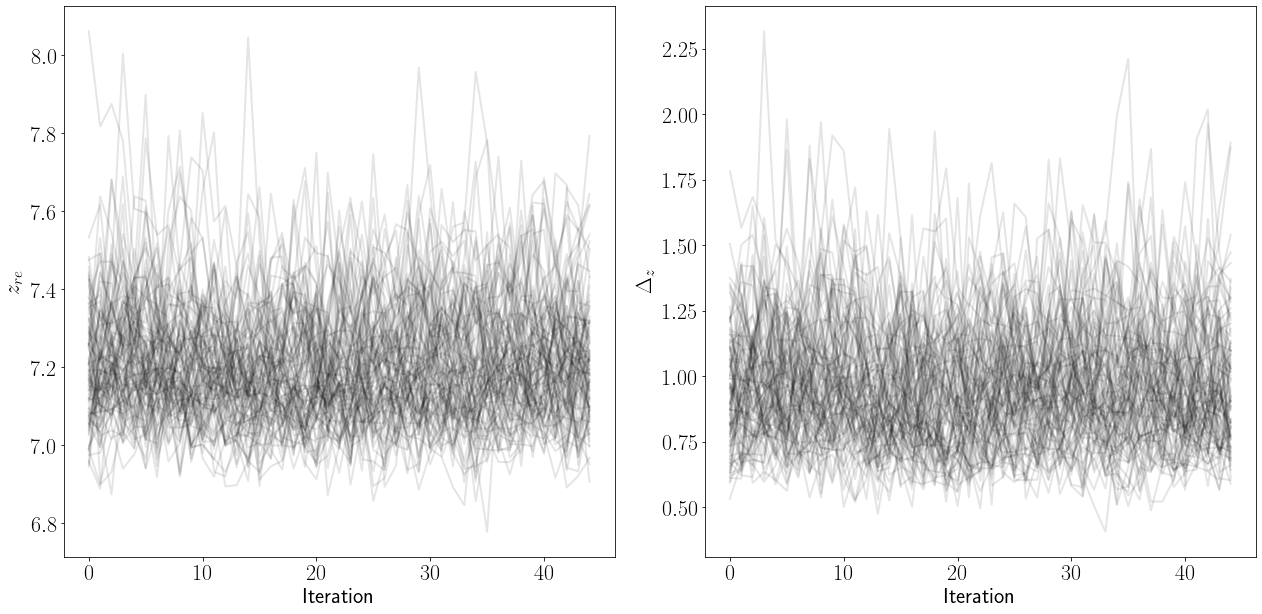

In [51]:
params = [ r'$z_{re}$',r'$\Delta_z$']
thin, discard = 10, 50
# plot traces of parameters
plt.figure(figsize=(18, 9))
for i in range(ndim):
    plt.subplot(1, 2, i+1)
    plt.plot(sampler.get_chain(thin=thin, discard=discard)[:, :, i]
    , color='black', alpha=0.1, lw=2)
    plt.xlabel('Iteration')
    plt.ylabel(params[i])
plt.tight_layout()



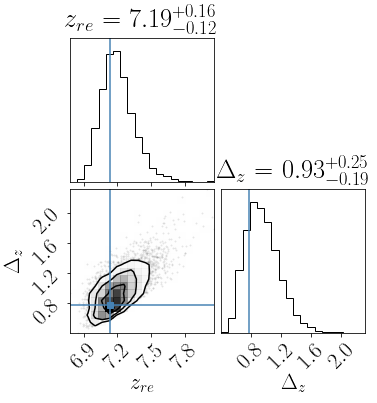

In [52]:
import corner
# plot 1-D, 2-D marginal distributions
fig=corner.corner(sampler.get_chain(thin=thin, discard=discard, flat=True),\
              labels=params, show_titles=True,truths=bestfit['x']);

fig.savefig("Reionization-Tanh.png")

## Bounds on the parameters

In [53]:
#samples[:, 1] = np.exp(samples[:, 1])
samples = sampler.chain[:, discard:, :].reshape((-1, ndim))
zre_mcmc, delta_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
print(zre_mcmc, delta_mcmc)

(7.188830874516388, 0.15915598374316708, 0.12227033169220736) (0.9303033753378609, 0.25176575341901253, 0.19415935377065663)


## Plotting the sample of reionization history

In [55]:
def xe_samples(params,zarray):
    zre,deltaz=params
    xe_samples=np.zeros(len(zarray))
    a_array=az(zarray)
    for i in range(len(zarray)):
        xe_samples[i]=xe(a_array[i],deltaz,zre)        
    return xe_samples 
    
z=np.linspace(0,25,100)





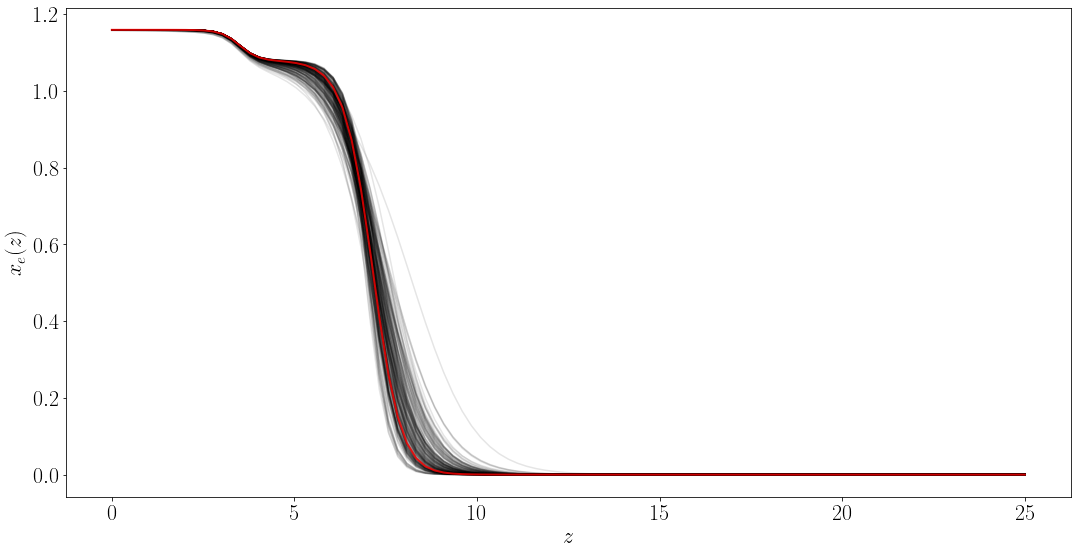

In [56]:
plt.figure(figsize=(18, 9))
for zrei, delz in samples[np.random.randint(len(samples), size=200)]:
    plt.plot(z, xe_samples([zrei,delz],z), color="k", alpha=0.1)        
plt.xlabel('$z$')
plt.ylabel('$x_e(z)$')
plt.plot(z, xe_samples([zre_bestfit,deltaz_bestfit],z), color="r", lw=2, alpha=0.8)
plt.savefig("Reionization-History-QHII-Tau.png")

## Assignments

1. Obtain reionization constraints from Douspis-Aghanim Parametrization (see, Planck2016 intermediate results. XLVII.Planck constraints on reionization history)

2. Remove the constraints on $Q_{HII}$ before $z=6.5$ and obtain constraints

3. Remove the constraints on $Q_{HII}$ after $z=6.5$ and obtain constraints